In [ ]:
"""
El objetivo es diseñar un sistema de recomendación de precios óptimos basado en comportamiento de usuarios, 
historial de transacciones y características de productos. 

Clientes objetivo:
- Equipo de pricing interno
- Vendedores premium
- Marcas que buscan optimizar conversiones y margen

Output esperado:
- Precio sugerido por producto
- Insights sobre elasticidad de demanda
- Segmentación de productos por sensibilidad al precio
"""


In [1]:
from pathlib import Path
import pandas as pd


In [2]:
# Path base
DATA_RAW = Path("../data/raw")

# Cargar datasets
users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")
products = pd.read_csv(DATA_RAW / "products.csv")

In [3]:
# Normalizar timestamps de eventos
events["event_timestamp"] = pd.to_datetime(events["timestamp"])

# Añadir precio a las transacciones
transactions = transactions.merge(products[["product_id", "price"]], on="product_id", how="left")
transactions["total_amount"] = transactions["quantity"] * transactions["price"]


# Calcular métricas por producto
product_metrics = transactions.groupby("product_id").agg(
    total_sales=("total_amount", "sum"),
    num_transactions=("transaction_id", "count"),
    avg_price=("price", "mean"),
    total_quantity=("quantity", "sum")
).reset_index()

# Elasticidad simplificada: precio promedio vs cantidad vendida
product_metrics["price_sensitivity"] = product_metrics["avg_price"] / (product_metrics["total_quantity"] + 1e-6)

product_metrics.head()

,product_id,total_sales,num_transactions,avg_price,total_quantity,price_sensitivity
0,1,13855.76,24,223.48,62,3.604516
1,2,4736.00,21,94.72,50,1.894400
2,3,657.00,19,14.60,45,0.324444
3,4,6053.58,21,155.22,39,3.980000
4,5,3733.12,28,49.12,76,0.646316


In [4]:
# Número de usuarios distintos que compraron cada producto
product_metrics["unique_buyers"] = transactions.groupby("product_id")["user_id"].nunique().values

# Frecuencia de compra relativa
product_metrics["purchase_frequency"] = product_metrics["num_transactions"] / product_metrics["unique_buyers"]

In [5]:
# Modelo de precio simplificado
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Features y target
X = product_metrics[["avg_price", "purchase_frequency", "unique_buyers"]]
y = product_metrics["total_sales"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_price_model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_price_model.fit(X_train, y_train)

# Predicciones y error
y_pred = rf_price_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Squared Error (MSE): 2887068.62


In [6]:
#  Predicción de precio recomendado
product_metrics["predicted_sales"] = rf_price_model.predict(X)

# Recomendación simple: ajustar precio según sensibilidad
product_metrics["recommended_price"] = product_metrics["avg_price"] * (1 + 0.1 * (product_metrics["price_sensitivity"] - product_metrics["price_sensitivity"].mean()))

product_metrics[["product_id","avg_price","recommended_price","predicted_sales"]].head()


,product_id,avg_price,recommended_price,predicted_sales
0,1,223.48,204.201378,13282.864080
1,2,94.72,70.350709,4918.310900
2,3,14.60,8.551619,687.601799
3,4,155.22,147.658123,7690.282638
4,5,49.12,30.351957,3303.770054


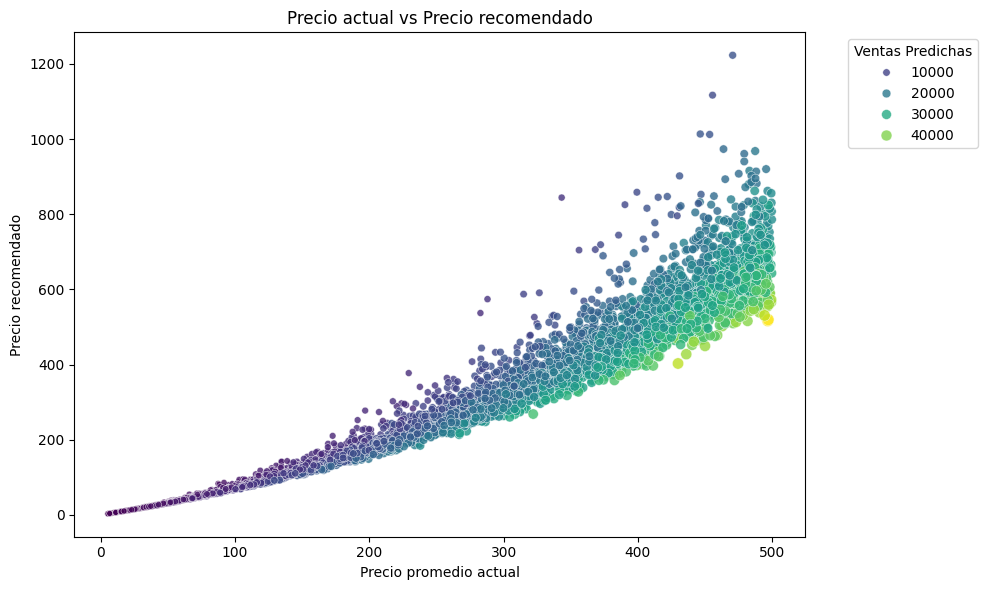

In [7]:
# Visualización de resultados

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=product_metrics,
    x="avg_price",
    y="recommended_price",
    size="predicted_sales",
    hue="predicted_sales",
    palette="viridis",
    alpha=0.8
)
plt.title("Precio actual vs Precio recomendado")
plt.xlabel("Precio promedio actual")
plt.ylabel("Precio recomendado")
plt.legend(title="Ventas Predichas", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Escenario de elasticidad de precio

import numpy as np
import pandas as pd

# Rango de escenarios de precio
price_shifts = [-0.2, -0.1, 0.0, 0.1, 0.2]  # -20%, -10%, 0%, +10%, +20%
scenario_rows = []

for shift in price_shifts:
    scenario = product_metrics.copy()
    scenario["scenario_price"] = scenario["avg_price"] * (1 + shift)
    
    # Actualizar la feature avg_price que usa el modelo
    scenario_features = scenario[["scenario_price", "purchase_frequency", "unique_buyers"]].rename(columns={"scenario_price":"avg_price"})
    
    # Predecir ventas para el escenario
    scenario["predicted_sales"] = rf_price_model.predict(scenario_features)
    scenario["price_shift"] = shift
    scenario_rows.append(scenario)

# Concatenar todos los escenarios
elasticity_df = pd.concat(scenario_rows)

# Calcular elasticidad aproximada: % cambio ventas / % cambio precio
elasticity_df["sales_change_pct"] = elasticity_df.groupby("product_id")["predicted_sales"].pct_change()
elasticity_df["price_change_pct"] = elasticity_df.groupby("product_id")["scenario_price"].pct_change()
elasticity_df["elasticity"] = elasticity_df["sales_change_pct"] / elasticity_df["price_change_pct"]

# Limpiar NaN generados por pct_change
elasticity_df = elasticity_df.dropna(subset=["elasticity"])

# Mostrar elasticidad promedio por producto
elasticity_summary = elasticity_df.groupby("product_id").agg(
    avg_elasticity=("elasticity", "mean"),
    base_price=("avg_price", "first"),
    predicted_sales_base=("predicted_sales", lambda x: x.iloc[1])  # el escenario 0% shift
).reset_index()

elasticity_summary.sort_values("avg_elasticity", ascending=False).head(10)

,product_id,avg_elasticity,base_price,predicted_sales_base
2667,2668,1.791525,7.51,429.783044
1902,1903,1.787535,7.41,411.348661
4656,4657,1.784611,455.61,11342.448837
3053,3054,1.756671,429.31,11168.563475
2287,2288,1.744565,14.75,1259.123075
2961,2962,1.679329,91.83,2284.650464
446,447,1.676265,399.29,11084.497116
1850,1851,1.656413,406.78,12480.564403
3404,3405,1.654039,17.58,865.665744
4783,4784,1.627530,404.10,13424.329191
